In [0]:
# -*- coding: utf-8 -*-
"""The Copy Task performed by LSTM cells using the tensorflow API"""
__author__ = "Aly Shmahell"
__copyright__ = "Copyright © 2019, Aly Shmahell"
__license__ = "All Rights Reserved"
__version__ = "0.1.0"
__maintainer__ = "Aly Shmahell"
__email__ = "aly.shmahell@gmail.com"
__status__ = "Alpha"

Epoch: 0, Error: 0.6932204365730286, Accuracy: 50.93749761581421
Epoch: 1, Error: 0.6591657400131226, Accuracy: 71.24999761581421
Epoch: 2, Error: 1.0532251596450806, Accuracy: 62.37499713897705
Epoch: 3, Error: 0.5596463084220886, Accuracy: 62.687498331069946
Epoch: 4, Error: 0.49227654933929443, Accuracy: 77.56249904632568
Epoch: 5, Error: 0.3458937108516693, Accuracy: 100.0
Epoch: 6, Error: 0.23896066844463348, Accuracy: 100.0
Epoch: 7, Error: 0.09811143577098846, Accuracy: 100.0
Epoch: 8, Error: 0.09719231724739075, Accuracy: 99.31250214576721
Epoch: 9, Error: 0.043847642838954926, Accuracy: 100.0
Epoch: 10, Error: 0.033192384988069534, Accuracy: 100.0
Epoch: 11, Error: 0.003949753008782864, Accuracy: 100.0
Epoch: 12, Error: 0.006129817571491003, Accuracy: 100.0
Epoch: 13, Error: 0.002030740724876523, Accuracy: 100.0
Epoch: 14, Error: 0.0020198493730276823, Accuracy: 100.0
Epoch: 15, Error: 0.0019289335468783975, Accuracy: 100.0
Epoch: 16, Error: 0.001898773480206728, Accuracy: 100

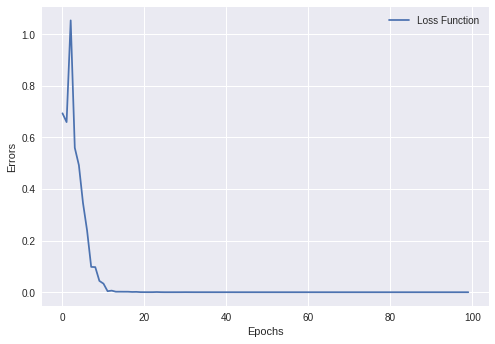

In [7]:
from __future__ import division
from __future__ import print_function
from __future__ import generator_stop 
from __future__ import unicode_literals
from __future__ import absolute_import

import sys
import os
import string
import itertools
from dataclasses import dataclass
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

tf.reset_default_graph()

@dataclass()
class Data(object):
    corpus: np.array
    symbols_ordered: dict
    symbols_reversed: dict
    corpus_size: int
    symbols_size: int
    def __init__(self):
        _text = """long ago , the mice had a general council to consider what measures they could take to outwit their common enemy ,
        the cat . some said this , and some said that but at last a young mouse got up and said he had a proposal to make , which he 
        thought would meet the case . you will all agree , said he , that our chief danger consists in the sly and treacherous manner 
        in which the enemy approaches us . now , if we could receive some signal of her approach , we could easily escape from her . 
        i venture , therefore , to propose that a small bell be procured , and attached by a ribbon round the neck of the cat . by this
        means we should always know when she was about , and could easily retire while she was in the neighbourhood . this proposal met 
        with general applause , until an old mouse got up and said  that is all very well , but who is to bell the cat ? the mice looked 
        at one another and nobody spoke . then the old mouse said it is easy to propose impossible remedies ."""
        self.corpus = [word for i in range(len([x.strip() for x in _text])) for word in [x.strip() for x in _text][i].split()]
        _counter = itertools.count(0)
        self.symbols_ordered = {chr(i):next(_counter) for i in range(128) if chr(i) in string.ascii_letters or chr(i) in string.digits or chr(i) in string.punctuation}
        self.symbols_reversed = dict(zip(self.symbols_ordered.values(), self.symbols_ordered.keys()))
        self.corpus_size = len(self.corpus)
        self.symbols_size = len(self.symbols_ordered)
data = Data()


def get_random_chunck(chunk_len):
    if chunk_len > data.corpus_size:
        sys.exit("chunk length exceeds the corpus length")
    _offset = np.random.randint(0, data.corpus_size-chunk_len-1)
    return data.corpus[_offset: _offset+chunk_len]
  
def cast_chunk_to_ints(chunk):
    return [data.symbols_ordered[c] for c in chunk]

def create_batch(num_samples):
    raw = [f"{i:>08b}" for i in cast_chunk_to_ints(get_random_chunck(num_samples))]
    np.random.shuffle(raw)
    raw = [list(map(int,i)) for i in raw]
    raw = np.array(raw)
    source = np.copy(raw)
    source = source.reshape(num_samples,8,1)
    target = np.copy(raw)
    target = target.reshape(num_samples,8)
    return source, target
  
def cast_result_to_str(result):
    return "".join([data.symbols_reversed[x] for x in [int("".join([str(y) for y in result[i]]),2) for i in range(len(result))]])

  
tf_source = tf.placeholder(tf.float32, shape=[None, None, 1])
tf_target = tf.placeholder(tf.int64, shape=[None, None])

lstm_units_count = 64
multi_rnn_cells = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(lstm_units_count, num_proj=2), tf.nn.rnn_cell.LSTMCell(lstm_units_count, num_proj=2)])
dynamic_rnn_output, _ = tf.nn.dynamic_rnn(multi_rnn_cells, tf_source, dtype=tf.float32) 

loss_function = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_target, logits=dynamic_rnn_output))
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss_function)

prediction = tf.argmax(dynamic_rnn_output, axis=2)
validity = tf.equal(tf_target, prediction)
precision = tf.reduce_mean(tf.cast(validity, tf.float32))
  
errors = []
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    for epoch in range(100):
        source, target = create_batch(200)
        _, error, accuracy = session.run([optimizer, loss_function, precision],feed_dict={tf_source: source, tf_target: target})
        print(f"Epoch: {epoch}, Error: {error}, Accuracy: {accuracy*100}")
        errors.append(error)
    source = [[[0],[1],[0],[0],[0],[1],[1],[1]], [[0],[1],[0],[0],[0],[1],[0],[0]], [[0],[1],[0],[1],[1],[0],[0],[0]]]
    print(f"Source: {cast_result_to_str(np.reshape(np.array(source), [3, 8]))}")
    print(f"Predicted: {cast_result_to_str(session.run(prediction,feed_dict={tf_source: source}))}")

plt.plot(errors,label="Loss Function")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.show()